This is a notebook started several weeks after the last notebook in analysis (TimeConstant6). It is using a completely new (and hopefully this time correct) version of the integral function $$\int \frac{1}{\sqrt{2 \pi p}} e^{\frac{-(q-q_0)^2}{2p^2}}cos{(2 \pi q(z-z_0))}dq$$

The complications that will arise will hopefully be worked out, leading to more accurate (and functional) ultimate results. 

Mira

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit
from scipy.special import erf

sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
import emcee
from scipy.integrate import quad
from scipy.integrate import nquad


ModuleNotFoundError: No module named 'emcee'

In [3]:
with open('../../data/raw_data/20170615_1730_20mms_reference.pkl', 'rb') as f:
    d = pickle.load(f, encoding='latin1') 

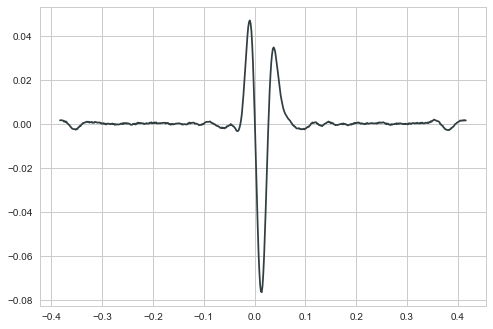

In [4]:
i = 9
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0

startpt = int(startpt)
endpt = int(endpt)
F = (d['sig0F']) 
D = F[startpt:endpt]
#D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

pl.plot(t,D)
pl.show()

In [5]:
#functions for getting the new integral model (from IntModel)
def integrand(q,z,z0,p,q0):
    return (1/(2*np.pi *p))*np.exp(-((q-q0)**2)/(2*p**2)) * np.cos(2*np.pi*q*(z-z0))

def integraled (z,z0,p,q0): 
    return quad(integrand, -50,50, args = (z,z0,p,q0))[0]

def extendintegral(qmin,qmax, z0, q0, p, div):
    y = []
    inot = []
    for i in np.linspace (qmin,qmax,div):
        y.append(-integraled(i,z0,p,q0))
        #inot.append(i)
    return y

#creating the SAME function based on Z??
def extendintegralVar(var,z0,q0,p):
    y = []
    for i in np.linspace(min(var), max(var), len(var)):
        y.append(-integraled(i,z0,p,q0))
    return y

In [6]:
#model function convoluted with RC circuit and AC coupling function 
#added the integral for first order
def psi1(z0,q0,p,T): #znot,qnot,p,T
    Ns = Nsize
    z = t
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    #qmin and qmax are guessed!!
    #y0 = extendintegral(-6,6,z0,q0,p,Ns)
    y0 = extendintegralVar(z,z0,q0,p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

In [7]:
#likelihood function
#why is it ln?
def lnlike(params, t, D): #znot,qnot,p,T
    znot, qnot,p1, T1,a = params 
    t,Modelf = psi1(znot,qnot,p1,T1)
    Dev = -.5*(np.dot((D-(Modelf*a)),D-(Modelf*a)))
    Sig=0.0005
    return (Dev/Sig)-np.log(1/Sig) #sigma? if sigma is large it becomes shallower

nll = lambda *args: -lnlike(*args) 
result = op.minimize(nll, [-.23,1.0,.4,0.0017 ,.0018], args=(t,D))
znot,qnot,p,T,a = result["x"]
print (result ["x"]) #znot,qnot,p,T

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys
/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


NameError: name 'quad' is not defined

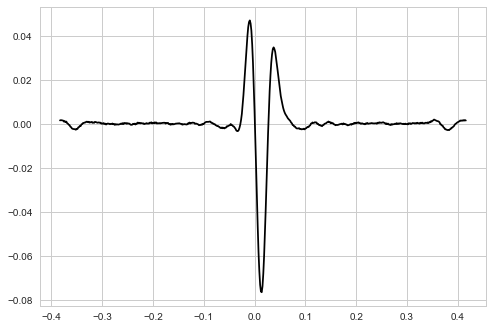

In [8]:
#VISUAL COMPARISON TO GUESS PARAMETERS BY EYE to put into optimals above.
#NO Model shift
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1(-.23,1,.4,0.0017 ) #znot,qnot,p,T,
#x,Modelf = psi1(0.098,9.99,-1034,10)

pl.plot(x,Modelf*(.0018), label = 'Model', color = 'red')
#pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()

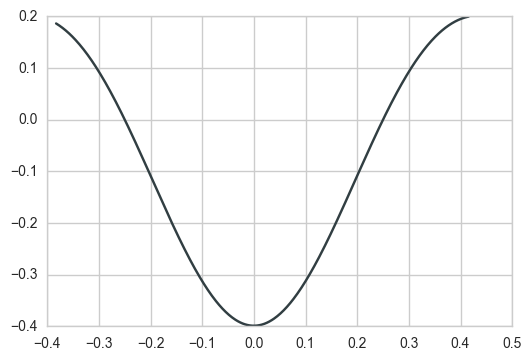

In [33]:
y0 = extendintegralVar(t,0,1,0.4) #-.23,1,.4,
pl.plot(t,y0)
pl.show()